# Assignment 4: LBA Decisions
## Quantified Cognition
### Psychology 5332


# Name: *Your Name Here*
# User ID: *Your ID Here*

# Objectives

Upon completion of this assignment, the student will demonstrate the ability to:

1. Simulate two models testing alternative hypotheses
2. Compare the fit for the two models
3. Evaluate and interpret the fit results


# Assignment

- The goal of this assignment is to analyze the choice--reaction time data from the perceptual decision-making task with a speed--accuracy trade-off. We want to explore potential mechanisms for how cognitive processing changes between the Speed vs. Accuracy conditions. 

- We will instantiate variants of the linear ballistic accumulator (LBA) that allow different parameters to vary between conditions. This allows us to test hypotheses about what aspects of the model change between conditions, while other aspects of the model remain the same. 

- You will perform this assignment by writing code in *this notebook* (***after making a copy and renaming it to have your userid in the title --- e.g., A04_LBA_decisions_mst3k***).

- In addition to this notebook, you will need to download the data from the same directory on GitHub. The file is decision_data.csv.

- ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***

## HINTS

- Be sure to comment your code
- I have provided cells with general instructions for what they should contain.
  

In [17]:
# Load in necessary modules
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

# load pieces from RunDEMC
from RunDEMC import Model, Param, dists
from RunDEMC.pda import PDA

from KDEpy import FFTKDE

In [2]:
# Read in the data from the decision_data.csv file to a Pandas DataFrame
# (This is data from a perceptual decision-making task, BTW)
dat = pd.read_csv('decision_data.csv', index_col='Unnamed: 0')

# get rid of the neutral condition
dat = dat[dat.cond != 'Neutral']


In [3]:
# Use the .head method of the DataFrame to show the first few lines of the file
# The columns are:
#   correct: whether they made a correct response (1=Correct, 0=Incorrect)
#   rt: their reaction time in seconds
#   cond: whether they were in a speeded, accuracy, or neutral condition
#   log_rt: log-transformed reaction time
dat.head(5)

,correct,rt,cond,log_rt
3,1,0.4784,Accuracy,-0.737308
4,1,0.4300,Accuracy,-0.843970
5,1,0.4486,Accuracy,-0.801624
6,1,0.3991,Speed,-0.918543
8,1,0.4393,Accuracy,-0.822573


## Code for the LBA model (from class)

The next few cells instantiate the LBA model and also fit a variant where we allow the threshold ($b$) to change between conditions.

In [4]:
def lba_sim(I=(1.0,1.5), A=.1, S=1.0, b=1.0, num_sims=1000,
            max_time=2., t0=0.0, **kwargs):
    # set drift rate from inputs
    dr = np.squeeze(np.atleast_1d(I))
    
    # set the number of choices
    nc = len(dr)
    
    # pick starting points
    k = np.random.uniform(0.,A,(num_sims,nc))
    
    # pick drifts
    # must make sure at least one d is greater than zero for each sim
    d = np.random.normal(dr,S,(num_sims,nc))
    
    ## see where there are none above zero
    #ind = np.all(d<=0.0,axis=1)
    #while np.any(ind):
    #    d[ind,:] = np.random.normal(dr,S,(ind.sum(),nc))
    #    ind = np.all(d<=0.0,axis=1)

    # clip it to avoid divide by zeros
    d[d<=0.0] = np.finfo(dr.dtype).eps

    # calc the times for each
    t = (b-k)/d

    # see the earliest for each resp
    inds = t.argmin(1)
    times = t.take(inds+np.arange(t.shape[0])*t.shape[1])

    # process into choices
    times += t0

    # get valid responses
    resp_ind = times < (max_time)
    inds[~resp_ind] = -1
    times[~resp_ind] = -1
    
    # make a dataframe
    return pd.DataFrame({'correct': inds, 'rt': times})

In [13]:
# plotting code
# normed histogram
def dhist(dat, nsims, alpha=.3, color='b'):
    p,b = np.histogram(dat,bins='auto',density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nsims
    return plt.bar(b[1:]-w,p,width=w,alpha=.3,color=color)

# normed pdf
xvals = np.linspace(0.1,2.0,100)
def dplot(dat, nsims, color='b', lw=2.):
    xp, fp = FFTKDE(kernel='gaussian', bw='silverman').fit(dat).evaluate()
    p = np.interp(xvals, xp, fp)
    p *= float(len(dat))/nsims
    plt.plot(xvals, p, color=color, lw=2.)

## Threshold change model (from class)

In [26]:
# Test change in threshold

# set up the params (note the two thresholds, b_A and b_S)
min_rt = dat.rt.min()
params = [Param(name='d1', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='d2', prior=dists.trunc_normal(1., 2., 0., 10.)),
          Param(name='A', prior=dists.trunc_normal(.5, 2.0, 0., 2.0)),
          Param(name='b_A', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='b_S', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0.0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]

# set up PDA
pda = PDA(dat.to_records(), cat_var='correct', 
          cont_var='rt', cond_var='cond')

# define the likelihood function
nsims = 10000
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first check for simple issues
        if (p['A'] > p['b_A']) or (p['A'] > p['b_S']) or \
            np.any(np.array(p.tolist())<0):
            # A can't be bigger than b
            # all params must be at least zero
            likes[i] = -np.inf
            continue
            
        # first Accuracy
        # run the simulation
        resA = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_A'], 
                      num_sims=nsims, max_time=2.0, t0=p['t0'])
        
        # add the cond column
        resA['cond'] = 'Accuracy'
        
        # then Speed
        resS = lba_sim(I=(p['d1'], p['d2']), A=p['A'], S=1.0, b=p['b_S'], 
                       num_sims=nsims, max_time=2.0, t0=p['t0'])   
        
        # add the cond column
        resS['cond'] = 'Speed'  
        
        # combine into one dataframe
        res = pd.concat([resA, resS], ignore_index=True)
        
        # calc log like via PDA
        likes[i] += pda.calc_log_like(res.to_records())
        if likes[i] == -np.inf:
            continue
        
    return likes
        
# make the model
m = Model('decisions_thresh', params=params,
          like_fun=like_fun,
          #like_args=(dat,),
          purify_every=5,
          pop_parallel=True, # set this to False if you have trouble on Windows
          verbose=True)

In [27]:
# only run burnin to get to max likelihood
times = m.sample(100, burnin=True)

Initializing: 120(120) 48(48) 18(18) 7(7) 4(4) 2(2) 
Iterations (100):


### Make sure the chains have reached max likelihood

They should have leveled off and not still be increasing.

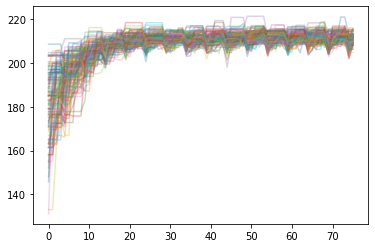

In [28]:
plt.plot(m.weights[25:], alpha=.3);

In [29]:
print("Best fitting params:")
burnin=5
best_ind = m.weights[burnin:].argmax()
best_weight = m.weights[burnin:].ravel()[best_ind]
print("Weight:", best_weight)
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))
    
# Caclculate bic
n = len(dat)
k = len(params)
L = best_weight
bic_thresh = np.log(n)*k - 2*(L)
print("BIC:", bic_thresh)

Best fitting params:
Weight: 221.43639910882132
"d1": 1.574324,
"d2": 2.627703,
"A": 0.456150,
"b_A": 1.273448,
"b_S": 0.727281,
"t0": 0.177385,
BIC: -403.1603643165393


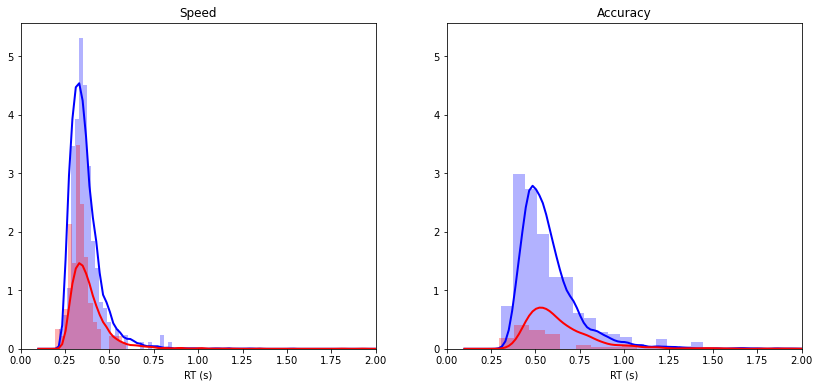

In [30]:
# Run sim with best fitting params
plt.figure(figsize=(14,6))
fig = plt.gcf()
ax1 = fig.add_subplot(121)

cond = 'Speed'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax = plt.subplot(1,2,1)
cdat = dat.loc[dat['cond']==cond]
ndat = len(cdat)
dhist(np.array(cdat.loc[(cdat['correct']==1), 'rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(cdat.loc[(cdat['correct']==0), 'rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond)

cond = 'Accuracy'

# run the LBA model
res = lba_sim(I=(pp['d1'], pp['d2']), A=pp['A'], S=1.0, b=pp['b_'+cond[0]], 
              num_sims=nsims, max_time=2.0, t0=pp['t0'])

# plot the hist of the data, followed by the model PDF line
ax2 = fig.add_subplot(122, sharey=ax1)
cdat = dat.loc[dat['cond']==cond]
ndat = len(cdat)
dhist(np.array(cdat.loc[(cdat['correct']==1), 'rt']), ndat, color='b')
dplot(np.array(res.rt[res.correct==1]), nsims, color='b')
dhist(np.array(cdat.loc[(cdat['correct']==0), 'rt']), ndat, color='r')
dplot(np.array(res.rt[res.correct==0]), nsims, color='r')
#ylim(0,5.0)
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title(cond);

## Test scaling of drift rates

Now we want to test the hypothesis that, instead of the threshold changing between the Speed and Accuracy conditions, the drift rates are scaled via some form of modulation. 

To do this, you'll want to copy all the notebook cells starting with the cell after the heading `Threshold Change Model` and make all the *minor* modifications necessary to test this hypothesized model. You'll need to:

- Change the parameters so there's just a single threshold
- Add a new param to scale the drift rates in one condition (any positive prior that is centered around 1.0 is fine)
- Modify the likelihood function to use the single threshold and the new multiplicative scaling term applied to the drift rates of *one* condition (NOT BOTH)

Once you've fit the model, use the BIC from the two models to calculate a Bayes Factor and discuss which one fit better. 

In [33]:
# Test model with scaling of drift rates



In [21]:
# only run burnin to get to max likelihood
times = m.sample(100, burnin=True)

Initializing: 120(120) 34(34) 7(7) 2(2) 
Iterations (100):


In [32]:
# extract best-fitting params and BIC


In [31]:
# Plot the sims with the best-fitting params 
# (note, you'll need to modify how the sims are run to match the new model)



## Evaluation

***Which model won? Why do you think it was the best-fitting model? Are there other model variants you can think to try?***

### Write your short answer here:
